In [2]:
import pandas as pd
import numpy as np
import csv
import re

In [400]:
data =[]
data.append(['Algo', 'TP', 'FN', 'TN', 'FP', 'Sensitivity', 'Specificity', 'Accuracy'])
falses = dict()

# CLINVAR table


In [401]:
clin2 = pd.read_csv('variants/notch1_clinvar.csv')
clin2 = clin2[['Protein_id','Position','Ref','Variant','Effect']].copy()
clin2.Effect.value_counts()

Benign        26
Pathogenic     7
Name: Effect, dtype: int64

# POLYPHEN table


In [402]:
#notch3 variants/batch_results/notch3_polyphen.txt
#notch1 variants/batch_results/notch1_polyphen.txt
pph = pd.read_table('variants/batch_results/notch1_polyphen.txt')
pph.head()

## Make normal names
names = pph.columns
new_names = []
for name in names:
    new_names.append(re.search(r'(\w+(-\w+)?)', name).group(0))
pph.columns = new_names

## Make normal pph2_class

res = list(pph['pph2_class'])
new_res = []
for r in res:
    new_res.append(re.search(r'[a-z]*$', r).group())
pph['pph2_class'] = new_res

#print(re.search(r'[a-z]*$', res[0]).group())

### New df with selected cols
pph2 = pph[['pos', 'aa1', 'aa2', 'prediction', 'pph2_class', 'pph2_FPR', 'pph2_TPR', 'pph2_FDR']]
pph2['Res'] = ['-' for i in range(len(pph2))]

#pph


/tmp/ipykernel_30348/1373562384.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph2['Res'] = ['-' for i in range(len(pph2))]


In [403]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(pph2)):
    if pph2['pph2_class'][i] == 'deleterious' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        pph2['Res'][i] = 'TP'
    if pph2['pph2_class'][i] == 'deleterious' and clin2['Effect'][i] == 'Benign':
        FP +=1
        pph2['Res'][i] = 'FP'
    if pph2['pph2_class'][i] == 'neutral' and clin2['Effect'][i] == 'Benign':
        TN +=1
        pph2['Res'][i] = 'TN' 
    if pph2['pph2_class'][i] == 'neutral' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        pph2['Res'][i] = 'FN'
print(TP, TN, FP, FN)
#pph2


/tmp/ipykernel_30348/4194895735.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph2['Res'][i] = 'FP'
/tmp/ipykernel_30348/4194895735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph2['Res'][i] = 'TN'
/tmp/ipykernel_30348/4194895735.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pph2['Res'][i] = 'TP'


7 16 10 0


In [404]:
Sens = TP/(TP+FN)
Spec = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
FDR = 1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5


#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP))
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)



#Sens = 0
data.append(['Polyphen',TP, FN, TN, FP, Sens,Spec,Acc])


Spec = 0.6153846153846154
Acc = 0.696969696969697
FDR = 0.5882352941176471


# PROVEAN table

In [405]:
# n1 variants/batch_results/notch1_prov.tsv
# n3 variants/batch_results/notch3_provean_sift.tsv


provean = pd.read_table('variants/batch_results/notch1_provean.tsv')
provean
prov2 = provean[['POSITION','RESIDUE_REF','RESIDUE_ALT','PREDICTION (cutoff=-2.5)', 'PREDICTION (cutoff=0.05)']]
prov2['res'] = ['-' for i in range(len(clin2.Protein_id))]
names = ['pos', 'ref', 'alt', 'provean', 'sift', 'res']
prov2.columns = names
#prov2


/tmp/ipykernel_30348/245815485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'] = ['-' for i in range(len(clin2.Protein_id))]


# Provean


In [406]:
TP = 0
TN = 0
FP = 0
FN = 0
prov_fp = []
prov_fn = []
for i in range(len(clin2.Protein_id)):
    if prov2['provean'][i] == 'Deleterious' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        prov2['res'][i] = 'TP'
    if prov2['provean'][i] == 'Deleterious' and clin2['Effect'][i] == 'Benign':
        FP +=1
        prov2['res'][i] = 'FP'
        prov_fp.append(f'NP_000426.2 {prov2.pos[i]} {prov2.ref[i]} {prov2.alt[i]}')
    if prov2['provean'][i] == 'Neutral' and clin2['Effect'][i] == 'Benign':
        TN +=1
        prov2['res'][i] = 'TN' 
    if prov2['provean'][i] == 'Neutral' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        prov2['res'][i] = 'FN'
        prov_fn.append(f'NP_000426.2 {prov2.pos[i]} {prov2.ref[i]} {prov2.alt[i]}')
print(TP, TN, FP, FN)



/tmp/ipykernel_30348/1123076465.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'TN'
/tmp/ipykernel_30348/1123076465.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'FP'
/tmp/ipykernel_30348/1123076465.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'TP'


7 22 4 0


In [407]:
Sens =TP/(TP+FN)
Spec =TN/(TN+FP)
Acc =(TP+TN)/(TP+TN+FP+FN)
FDR =1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5



#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP))
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)

#Sens = 0
data.append(['Provean', TP, FN, TN, FP, Sens,Spec,Acc])


Spec = 0.8461538461538461
Acc = 0.8787878787878788
FDR = 0.36363636363636365


# SIFT

In [408]:
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(len(clin2.Protein_id)):
    if prov2['sift'][i] == 'Damaging' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        prov2['res'][i] = 'TP'
    if prov2['sift'][i] == 'Damaging' and clin2['Effect'][i] == 'Benign':
        FP +=1
        prov2['res'][i] = 'FP'
    if prov2['sift'][i] == 'Tolerated' and clin2['Effect'][i] == 'Benign':
        TN +=1
        prov2['res'][i] = 'TN' 
    if prov2['sift'][i] == 'Tolerated' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        prov2['res'][i] = 'FN'
print(TP, TN, FP, FN)
#prov2


/tmp/ipykernel_30348/3361778008.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'TN'
/tmp/ipykernel_30348/3361778008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'TP'
/tmp/ipykernel_30348/3361778008.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prov2['res'][i] = 'FN'
/tmp/ipykernel_30348/3361778008.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

6 23 3 1


In [409]:
Sens =TP/(TP+FN)
Spec = TN/(TN+FP)
Acc = (TP+TN)/(TP+TN+FP+FN)
FDR = 1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5

#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP))
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)

#Sens = 0
data.append(['SIFT', TP, FN, TN, FP, Sens,Spec,Acc])



Spec = 0.8846153846153846
Acc = 0.8787878787878788
FDR = 0.33333333333333337


# Straightforward table

In [410]:
#n1 ~/Documents/study/project2022_notch/alg_predictions/n1_sf_predictions.csv
#n3 ~/Documents/study/project2022_notch/alg_predictions/n3_sf_predictions.csv

#stf = pd.read_csv('~/Documents/study/project2022_notch/notch3_sf_predictions.csv')
stf = pd.read_csv('n1_stf_test.csv')
stf['Res'] = ['-' for i in range(len(clin2.Protein_id))]

for i in range(len(stf)):
    if stf.Prediction[i] in ['Benign?', 'Benign??']:
        stf.Prediction[i] = 'Benign'
    if stf.Prediction[i] == 'Pathogenic?':
        stf.Prediction[i] = 'Pathogenic'



TP = 0
TN = 0
FP = 0
FN = 0
stf_tp = []
stf_tn = []
for i in range(len(clin2.Protein_id)):
    if stf['Prediction'][i] == 'Pathogenic' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        stf['Res'][i] = 'TP'
        stf_tp.append(stf.Input[i])
    if stf['Prediction'][i] == 'Pathogenic' and clin2['Effect'][i] == 'Benign':
        FP +=1
        stf['Res'][i] = 'FP'
    if stf['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Benign':
        TN +=1
        stf['Res'][i] = 'TN' 
        stf_tn.append(stf.Input[i])
    if stf['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        stf['Res'][i] = 'FN'
print(TP, TN, FP, FN)


4 24 0 1


In [411]:
stf.Prediction.unique()

array(['Benign', 'Unknown', 'Pathogenic'], dtype=object)

In [412]:
Sens =TP/(TP+FN)
Spec =TN/(TN+FP) if TN!=0 else 0
Acc =(TP+TN)/(TP+TN+FP+FN)
FDR =1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5


#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP) if TN!=0 else 0)
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)


#Sens = 0
data.append(['Straight_no_uncert', TP, FN, TN, FP, Sens,Spec,Acc])


Spec = 1.0
Acc = 0.9655172413793104
FDR = 0.0


In [413]:

TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(clin2.Protein_id)):
    if stf['Prediction'][i] == 'Pathogenic' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        stf['Res'][i] = 'TP'
    if stf['Prediction'][i] == 'Pathogenic' and clin2['Effect'][i] == 'Benign':
        FP +=1
        stf['Res'][i] = 'FP'
    if stf['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Benign':
        TN +=1
        stf['Res'][i] = 'TN' 
    if stf['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        stf['Res'][i] = 'FN'
    if stf['Prediction'][i] == 'Unknown' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        stf['Res'][i] = 'FN'
    if stf['Prediction'][i] == 'Unknown' and clin2['Effect'][i] == 'Benign':
        FP +=1
        stf['Res'][i] = 'FP'
print(TP, TN, FP, FN)

4 24 2 3


In [414]:
Sens =TP/(TP+FN)
Spec =TN/(TN+FP) if TN!=0 else 0
Acc =(TP+TN)/(TP+TN+FP+FN)
FDR =1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5


#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP) if TN!=0 else 0)
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)

#Sens = 0
data.append(['Straight_with_uncert', TP, FN, TN, FP, Sens,Spec,Acc])


Spec = 0.9230769230769231
Acc = 0.8484848484848485
FDR = 0.33333333333333337


### SAVER


In [415]:
saver = pd.read_csv('n1_saver_test.csv')
saver['Res'] = ['-' for i in range(len(clin2.Protein_id))]

TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(clin2.Protein_id)):
    if saver['Prediction'][i] == 'Damaging' and clin2['Effect'][i] == 'Pathogenic':
        TP +=1
        saver['Res'][i] = 'TP'
        
    if saver['Prediction'][i] == 'Damaging' and clin2['Effect'][i] == 'Benign':
        FP +=1
        saver['Res'][i] = 'FP'
    if saver['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Benign':
        TN +=1
        saver['Res'][i] = 'TN' 

    if saver['Prediction'][i] == 'Benign' and clin2['Effect'][i] == 'Pathogenic':
        FN +=1
        saver['Res'][i] = 'FN'
print(TP, TN, FP, FN)

/tmp/ipykernel_30348/3278054366.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saver['Res'][i] = 'FP'
/tmp/ipykernel_30348/3278054366.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saver['Res'][i] = 'TN'
/tmp/ipykernel_30348/3278054366.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  saver['Res'][i] = 'TP'


7 19 7 0


In [416]:
Sens =TP/(TP+FN)
Spec =TN/(TN+FP) if TN!=0 else 0
Acc =(TP+TN)/(TP+TN+FP+FN)
FDR =1 - (TP/(TP+FP))
#MCC =((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5


#print('Sens =', TP/(TP+FN))
print('Spec =', TN/(TN+FP) if TN!=0 else 0)
print('Acc =', (TP+TN)/(TP+TN+FP+FN))
print('FDR =', 1 - (TP/(TP+FP)))
#print('MCC =', ((TP*TN)-(FP*FN))/((TP+FP)*(TP+FN)*(TN+FN)*(TN+FP))**0.5)

#Sens = 0
data.append(['Saver', TP, FN, TN, FP, Sens,Spec,Acc])


Spec = 0.7307692307692307
Acc = 0.7878787878787878
FDR = 0.5


In [417]:
#with open('Stats.csv', 'w', encoding='UTF8') as f:
with open('n1_Stats.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerows(data)

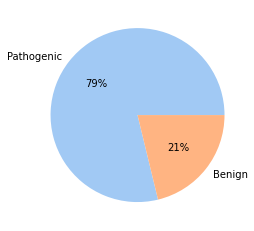

In [418]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = clin2['Effect'].value_counts()
labels = ['Pathogenic', 'Benign']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

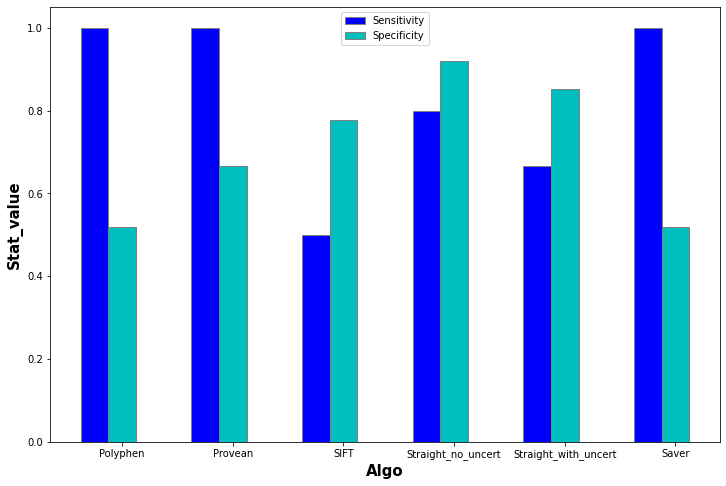

In [3]:
import numpy as np
import matplotlib.pyplot as plt

stats = pd.read_csv('n2_Stats.csv')


# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
Sensitivity = list(stats.Sensitivity)
Specificity = list(stats.Specificity)

 
# Set position of bar on X axis
br1 = np.arange(len(Sensitivity))
br2 = [x + barWidth for x in br1]
 
# Make the plot
plt.bar(br1, Sensitivity, color ='b', width = barWidth,
        edgecolor ='grey', label ='Sensitivity')
plt.bar(br2, Specificity, color ='c', width = barWidth,
        edgecolor ='grey', label ='Specificity')

 
# Adding Xticks
plt.xlabel('Algo', fontweight ='bold', fontsize = 15)
plt.ylabel('Stat_value', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Sensitivity))],
        list(stats.Algo))
 
plt.legend()
plt.show()

In [420]:
stats

,Algo,TP,FN,TN,FP,Sensitivity,Specificity,Accuracy
0,Polyphen,7,0,16,10,1.000000,0.615385,0.696970
1,Provean,7,0,22,4,1.000000,0.846154,0.878788
2,SIFT,6,1,23,3,0.857143,0.884615,0.878788
3,Straight_no_uncert,4,1,24,0,0.800000,1.000000,0.965517
4,Straight_with_uncert,4,3,24,2,0.571429,0.923077,0.848485
5,Saver,7,0,19,7,1.000000,0.730769,0.787879


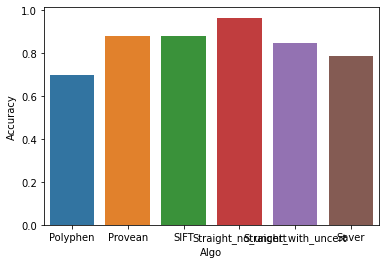

In [421]:
import seaborn as sns
ax = sns.barplot(x="Algo", y = 'Accuracy',data=stats)

Look for variants:

In [422]:
pos = []
for i in range(len(clin2.Protein_id)):
    if stf['Prediction'][i] == '' and clin2['Effect'][i] == 'Pathogenic':
        pos.append(stf['Input'][i])



In [423]:
# 129 path in clinvar + 37 benign
# 99 true path in sf (30 uncert)
len(pos)
#for i in pos:
#    print(i)



0

In [424]:
pos = []
for i in range(len(clin2.Protein_id)):
    if (stf['Prediction'][i] == 'Damaging' or stf['Prediction'][i] == 'likely Damaging') and clin2['Effect'][i] == 'Benign':
        pos.append(stf.Input[i])
pos

[]

In [425]:
for i in prov_fp:
    print(stf[stf['Input']== i]['Prediction'])


Series([], Name: Prediction, dtype: object)
Series([], Name: Prediction, dtype: object)
Series([], Name: Prediction, dtype: object)
Series([], Name: Prediction, dtype: object)


In [ ]:
prov2[prov2['pos'] == 420]


,pos,ref,alt,provean,sift,res
80,420,G,C,Neutral,Tolerated,FN
